# Определение возраста покупателей

# Проект для супермаркета «Хлеб-Соль»

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

---
**Задачи исследования:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

---

**Цель исследования** - построить модель, которая по фотографии определить приблизительный возраст человека.

---

**Описание данных**

Данные для анализа взяты с сайта ChaLearn Looking at People.

Данные находятся в папке /datasets/faces/: одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками:

- 'file_name' - названия файлов
- 'real_age' - возраст людей, изображенных в файлах (целевой признак)

## Подготовка

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

plt.rcParams["figure.figsize"] = (15, 8)

###  Загрузка данных

In [2]:
pth = '/datasets/faces/labels.csv'

if os.path.exists(pth):
    data = pd.read_csv(pth)
else:
    print('Something is wrong')

## Исследовательский анализ данных

### Изучение общей информации

In [3]:
#Выведем первые строки датафрейма
display(data.head())
print('*' * 125)

#Выведем общую информацию
data.info()
print('*' * 125)

#Выведем описание данных
display(data.describe().T)
print('*' * 125)

print('Количество явных дубликатов в датафрейте:', data.duplicated().sum())
print('Количество пропусков в датафрейте:', data.isna().sum())
print('Размер выборки:', data.shape)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


*****************************************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
*****************************************************************************************************************************


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


*****************************************************************************************************************************
Количество явных дубликатов в датафрейте: 0
Количество пропусков в датафрейте: file_name    0
real_age     0
dtype: int64
Размер выборки: (7591, 2)


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


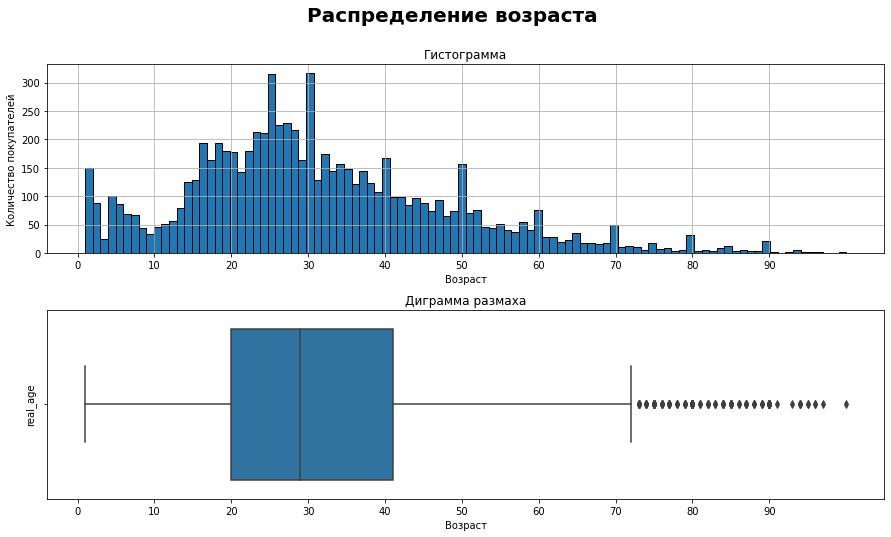

In [4]:
# построим график распределения возраста в выборке
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'Распределение возраста', fontsize = 20, fontweight='bold')

data.hist(bins=100, edgecolor='black', ax=ax[0])

sns.boxplot(data['real_age'], ax=ax[1])

ax[0].set_title('Гистограмма')
ax[0].set_xlabel('Возраст')
ax[0].set_ylabel('Количество покупателей')
ax[0].set_xticks(np.arange(0,100,10))
    
ax[1].set_title('Диграмма размаха')
ax[1].set_xlabel('Возраст')
ax[1].set_ylabel('real_age')
ax[1].set_xticks(np.arange(0,100,10))

plt.show()

### Вывод изображений

In [5]:
#Cоздаем объект ImageDataGenerator, который будет использоваться для преобразования и подготовки данных изображений. 
datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

In [6]:
features, target = next(gen_flow)

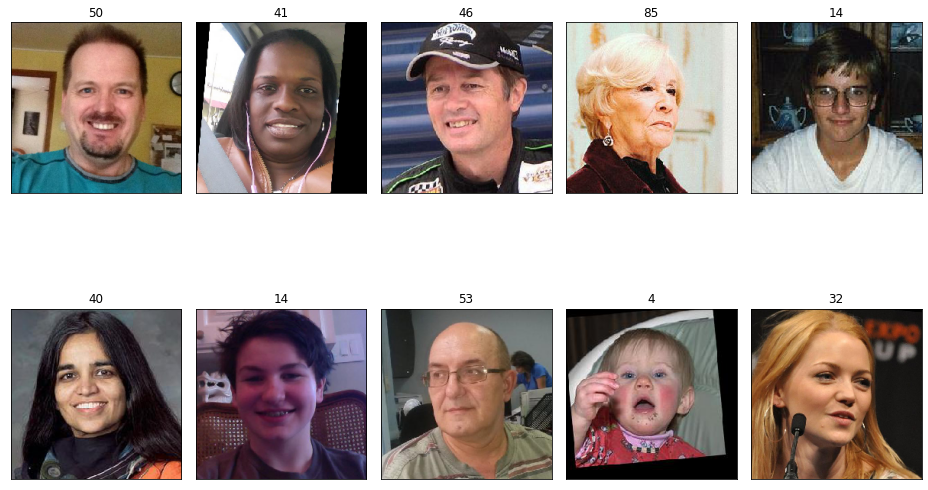

In [7]:
# выведем на экран 10 фотографий
fig = plt.figure(figsize=(13,13))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(target[i])
    plt.tight_layout()

На фотографиях изображены лица людей с указанием возраста. Причем, некоторые фотографии расположены под углом, учтем это при обучении модели

**Вывод** Данные в датасете соответствуют описанию.

Количество строк - 7 591, Количество столбцов - 2. 

Тип данных указан верно, пропусков и дубликатов в датафрейме нет, название столбцов соответствуют стилю написания snake_case.

Минимальный возраст покупателя 1 год, максимальный 100 лет. В данных есть всплески кратные 10 лет. Средний возраст покупателя 29 лет, медианное значение 41 год.

Часть фотографий расположены под углом, учтем это при обучении модели. 

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

#функция загрузки обучающей выборки
def load_train(path):

	labels = pd.read_csv(path + 'labels.csv')
	datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
	train_gen_flow = datagen.flow_from_dataframe(
    		dataframe=labels,
    		directory=path + 'final_files/',
    		x_col='file_name',
    		y_col='real_age',
    		target_size=(224, 224),
    		batch_size=16,
    		subset='training',
    		class_mode='raw',
    		seed=12345)

	return train_gen_flow

#функция загрузки тестовой выборки
def load_test(path):

	labels = pd.read_csv(path + 'labels.csv')
	datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
	test_gen_flow = datagen.flow_from_dataframe(
    		dataframe=labels,
    		directory=path + 'final_files/',
    		x_col='file_name',
    		y_col='real_age',
    		target_size=(224, 224),
    		batch_size=16,
    		class_mode='raw',
    		subset='validation',
    		seed=12345)

	return test_gen_flow

#функция создания модели нейросети
def create_model(input_shape):

	backbone = ResNet50(input_shape=input_shape,
                weights='imagenet', 
                include_top=False)

	model = Sequential()
	model.add(backbone)
	model.add(GlobalAveragePooling2D())
	model.add(Dense(1, activation='relu'))

	optimizer = Adam(lr=0.0001)
	model.compile(optimizer=optimizer, loss='mean_squared_error',
              metrics=['mae'])

	return model	

#функция обучения модели нейросети	
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

	if steps_per_epoch is None:
    		steps_per_epoch = len(train_data)
	if validation_steps is None:
    		validation_steps = len(test_data)

	model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size, 
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          verbose=2)

	return model

```

**Вывод функции на экран**

```
Train for 356 steps, validate for 119 steps

Epoch 1/10
356/356 - 81s - loss: 190.7682 - mae: 10.0264 - val_loss: 772.4664 - val_mae: 22.8533
Epoch 2/10
356/356 - 45s - loss: 83.7634 - mae: 6.9470 - val_loss: 124.0767 - val_mae: 8.6036
Epoch 3/10
356/356 - 44s - loss: 56.2461 - mae: 5.7208 - val_loss: 104.9746 - val_mae: 7.5528
Epoch 4/10
356/356 - 44s - loss: 41.0875 - mae: 4.9191 - val_loss: 69.9348 - val_mae: 6.2416
Epoch 5/10
356/356 - 45s - loss: 32.6001 - mae: 4.3069 - val_loss: 67.4870 - val_mae: 6.1200
Epoch 6/10
356/356 - 45s - loss: 23.7030 - mae: 3.7557 - val_loss: 71.3476 - val_mae: 6.3342
Epoch 7/10
356/356 - 44s - loss: 19.1444 - mae: 3.3610 - val_loss: 70.0721 - val_mae: 6.1961
Epoch 8/10
356/356 - 44s - loss: 17.2542 - mae: 3.1840 - val_loss: 64.2259 - val_mae: 5.9428
Epoch 9/10
356/356 - 45s - loss: 14.5719 - mae: 2.9355 - val_loss: 61.7683 - val_mae: 5.7800
Epoch 10/10
356/356 - 46s - loss: 12.5458 - mae: 2.6677 - val_loss: 61.1625 - val_mae: 5.8188

119/119 - 11s - loss: 61.1625 - mae: 5.8188

Test MAE: 5.8188

```

Значение MAE на тестовой выборке 5.8188

## Анализ обученной модели

Обучение модели запускали в отдельном GPU-тренажёре.

Перед обучением модели масштабировали фотографии и выровняли их горизонтально. Создали последовательную модель, с тремя слоями:
- базовый блок ResNet50
- слой глобальной средней обработки
- линейный слой с активацией ReLU.

Добавили оптимизатор Adam с learning rate 0.0001 и компилируем модель с целью минимизации mean squared error и метрикой mean absolute error.

Значение  MAE на тестовой выборке получилось 5.8188, что соответствует условию задачи. Это означает, что наша модель ошибается не более, чем на 5,8 лет. 

Чтобы повысить качество модели рекомендую дополнить базу покупателями возраста старше 50 лет и подростками 10-15 лет, сейчас основная масса покупателей представлена в возрасте 20-40 лет.

Данная модель не рекомендована для контроля продажи алкоголя, но может успешно использоваться для анализа покупок и специализированных предложений в зависимости от возраста покупателей.


## Общий вывод

# Проект для супермаркета «Хлеб-Соль»

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

---
**Задачи исследования:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

---

**Цель исследования** - построить модель, которая по фотографии определить приблизительный возраст человека.

---

**Описание данных**

Данные для анализа взяты с сайта ChaLearn Looking at People.

Данные находятся в папке /datasets/faces/: одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками:

- 'file_name' - названия файлов
- 'real_age' - возраст людей, изображенных в файлах (целевой признак)
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерн

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

---
**Задачи исследования:**

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитайте её качество.

---

**Цель исследования** - построить модель, которая по фотографии определит приблизительный возраст человека.

---

**Описание данных**

Данные для анализа взяты с сайта ChaLearn Looking at People.

Данные находятся в папке /datasets/faces/: одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками:

- 'file_name' - названия файлов
- 'real_age' - возраст людей, изображенных в файлах (целевой признак)

---

**Исследовательский анализ данных**

Данные в датасете соответствуют описанию.

Количество строк - 7 591, Количество столбцов - 2. 

Тип данных указан верно, пропусков и дубликатов в датафрейме нет, название столбцов соответствуют стилю написания snake_case.

Минимальный возраст покупателя 1 год, максимальный 100 лет. В данных есть всплески кратные 10 лет. Средний возраст покупателя 29 лет, медианное значение 41 год.

Часть фотографий расположены под углом, учтем это при обучении модели. 

---

**Обучение модели**

Обучение модели запускали в отдельном GPU-тренажёре.

Перед обучением модели масштабировали фотографии и выровняли их горизонтально. Создали последовательную модель, с тремя слоями:
- базовый блок ResNet50
- слой глобальной средней обработки
- линейный слой с активацией ReLU.

Добавили оптимизатор Adam с learning rate 0.0001 и компилируем модель с целью минимизации mean squared error и метрикой mean absolute error.

Значение  MAE на тестовой выборке получилось 5.8188, что соответствует условию задачи. Это означает, что наша модель ошибается не более, чем на 5,8 лет. 

Чтобы повысить качество модели рекомендую дополнить базу покупателями возраста старше 50 лет и подростками 10-15 лет, сейчас основная масса покупателей представлена в возрасте 20-40 лет.

Данная модель не рекомендована для контроля продажи алкоголя, но может успешно использоваться для анализа покупок и специализированных предложений в зависимости от возраста покупателей.
